In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

from skimage.morphology import closing, square
from tools import *
from plot import *

In [2]:
indiana_img = np.load('../data/indianapines.npy')
indiana_labels = np.load('../data/indianapines_gt.npy')
salinas_img = np.load('../data/salinas.npy')
salinas_labels = np.load('../data/salinas_gt.npy')

In [3]:
# normalize radiance values to get reflectance values
indiana_img = indiana_img / indiana_img.max()
salinas_img = salinas_img / salinas_img.max()

In [4]:
print("Indiana shape: {}".format(indiana_img.shape))
print("Salinas shape: {}".format(salinas_img.shape))

Indiana shape: (145, 145, 200)
Salinas shape: (512, 217, 204)


In [5]:
X_indiana = indiana_img.reshape((-1, indiana_img.shape[-1])) # reshaping the HSI as a 2D matrix
print("Indiana shape: {}".format(X_indiana.shape))

X_salinas = salinas_img.reshape((-1, salinas_img.shape[-1])) # reshaping the HSI as a 2D matrix
print("Salinas shape: {}".format(X_salinas.shape))

Indiana shape: (21025, 200)
Salinas shape: (111104, 204)


In [6]:
n_cluster_indiana = len(np.unique(indiana_labels)) - 1
n_cluster_salinas = len(np.unique(salinas_labels)) - 1

## Remove unclassified data

In [7]:
X_indiana, X_indiana_idx = remove_unclassified_input(X_indiana, indiana_labels)
X_salinas, X_salinas_idx = remove_unclassified_input(X_salinas, salinas_labels)

In [8]:
print(X_indiana.shape)
print(X_indiana_idx.shape)
print(X_salinas.shape)

(10249, 200)
(10249,)
(54129, 204)


In [9]:
indiana_labels, _ = remove_unclassified_input(indiana_labels.flatten(), indiana_labels)
salinas_labels, _ = remove_unclassified_input(salinas_labels.flatten(), salinas_labels)

In [10]:
print(indiana_labels.shape)
print(salinas_labels.shape)

(10249,)
(54129,)


## PCA

In [11]:
n_components_indiana = get_number_components(X_indiana)
n_components_salinas = get_number_components(X_salinas)

Fitting the PCA
Fitting the PCA


In [12]:
print("Number of components Indiana: {}".format(n_components_indiana))
print("Number of components Salinas: {}".format(n_components_salinas))

Number of components Indiana: 68
Number of components Salinas: 5


In [13]:
X_indiana_reduced = extract_features(X_indiana, n_components_indiana)
X_salinas_reduced = extract_features(X_salinas, n_components_salinas)

In [14]:
print("Indiana reduced data shape: {}".format(X_indiana_reduced.shape))
print("Salinas reduced data shape: {}".format(X_salinas_reduced.shape))

Indiana reduced data shape: (10249, 68)
Salinas reduced data shape: (54129, 5)


## Split train / test

In [15]:
# shuffle manually
X_indiana_shuffle, indiana_labels_shuffle, shuffle_arr_indiana = shuffle(X_indiana_reduced, indiana_labels)
X_salinas_shuffle, salinas_labels_shuffle, shuffle_arr_salinas = shuffle(X_salinas_reduced, salinas_labels)

# shuffle index
#X_indiana_idx[np.arange(indiana_labels_shuffle.size)] = X_indiana_idx[shuffle_arr]

In [16]:
unmapping_shuffle_indiana = np.empty(shuffle_arr_indiana.size,  dtype=int)
unmapping_shuffle_indiana[shuffle_arr_indiana] = np.arange(shuffle_arr_indiana.size)

In [17]:
# nb_test = int(X_indiana_shuffle.shape[0] * 0.25)
# X_train_indiana = X_indiana_shuffle[nb_test:]
# y_train_indiana = indiana_labels_shuffle[nb_test:]
# X_test_indiana = X_indiana_shuffle[:nb_test]
# y_test_indiana = indiana_labels_shuffle[:nb_test]

In [18]:
y_indiana_labels_argsort = np.argsort(indiana_labels_shuffle)
y_salinas_labels_argsort = np.argsort(salinas_labels_shuffle)

In [19]:
#unmapping_argsort = np.argsort(y_indiana_labels_argsort)

In [20]:
for i in range(1, n_cluster_indiana + 1):
    print(indiana_labels_shuffle[indiana_labels_shuffle == i].size)    

46
1428
830
237
483
730
28
478
20
972
2455
593
205
1265
386
93


In [21]:
labels_indiana, count_indiana = np.unique(indiana_labels_shuffle-1, return_counts=True)
labels_salinas, count_salinas = np.unique(salinas_labels_shuffle-1, return_counts=True)

In [22]:
x_train_indiana, x_test_indiana, y_train_indiana_labels, y_test_indiana_labels = split_x_train_test(X_indiana_shuffle, count_indiana, labels_indiana, y_indiana_labels_argsort, (0, n_components_indiana))

Cluster: 0
Nb total samples: 46
Nb samples train: 34
Nb samples test: 12
---------------
Cluster: 1
Nb total samples: 1428
Nb samples train: 1071
Nb samples test: 357
---------------
Cluster: 2
Nb total samples: 830
Nb samples train: 622
Nb samples test: 208
---------------
Cluster: 3
Nb total samples: 237
Nb samples train: 177
Nb samples test: 60
---------------
Cluster: 4
Nb total samples: 483
Nb samples train: 362
Nb samples test: 121
---------------
Cluster: 5
Nb total samples: 730
Nb samples train: 547
Nb samples test: 183
---------------
Cluster: 6
Nb total samples: 28
Nb samples train: 21
Nb samples test: 7
---------------
Cluster: 7
Nb total samples: 478
Nb samples train: 358
Nb samples test: 120
---------------
Cluster: 8
Nb total samples: 20
Nb samples train: 15
Nb samples test: 5
---------------
Cluster: 9
Nb total samples: 972
Nb samples train: 729
Nb samples test: 243
---------------
Cluster: 10
Nb total samples: 2455
Nb samples train: 1841
Nb samples test: 614
-----------

In [23]:
x_train_salinas, x_test_salinas, y_train_salinas_labels, y_test_salinas_labels = split_x_train_test(X_salinas_shuffle, count_salinas, labels_salinas, y_salinas_labels_argsort, (0, n_components_salinas))

Cluster: 0
Nb total samples: 2009
Nb samples train: 1506
Nb samples test: 503
---------------
Cluster: 1
Nb total samples: 3726
Nb samples train: 2794
Nb samples test: 932
---------------
Cluster: 2
Nb total samples: 1976
Nb samples train: 1482
Nb samples test: 494
---------------
Cluster: 3
Nb total samples: 1394
Nb samples train: 1045
Nb samples test: 349
---------------
Cluster: 4
Nb total samples: 2678
Nb samples train: 2008
Nb samples test: 670
---------------
Cluster: 5
Nb total samples: 3959
Nb samples train: 2969
Nb samples test: 990
---------------
Cluster: 6
Nb total samples: 3579
Nb samples train: 2684
Nb samples test: 895
---------------
Cluster: 7
Nb total samples: 11271
Nb samples train: 8453
Nb samples test: 2818
---------------
Cluster: 8
Nb total samples: 6203
Nb samples train: 4652
Nb samples test: 1551
---------------
Cluster: 9
Nb total samples: 3278
Nb samples train: 2458
Nb samples test: 820
---------------
Cluster: 10
Nb total samples: 1068
Nb samples train: 801


In [24]:
print("Train shape: {}".format(x_train_indiana.shape))
print("Train labels shape: {}".format(y_train_indiana_labels.shape))
print("Test shape: {}".format(x_test_indiana.shape))
print("Test labels shape: {}".format(y_test_indiana_labels.shape))

Train shape: (7680, 68)
Train labels shape: (7680,)
Test shape: (2569, 68)
Test labels shape: (2569,)


In [25]:
print("Train shape: {}".format(x_train_salinas.shape))
print("Train labels shape: {}".format(y_train_salinas_labels.shape))
print("Test shape: {}".format(x_test_salinas.shape))
print("Test labels shape: {}".format(y_test_salinas_labels.shape))

Train shape: (40592, 5)
Train labels shape: (40592,)
Test shape: (13537, 5)
Test labels shape: (13537,)


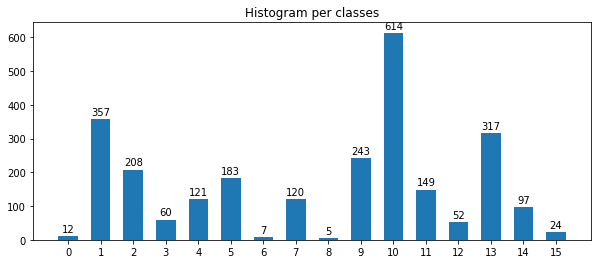

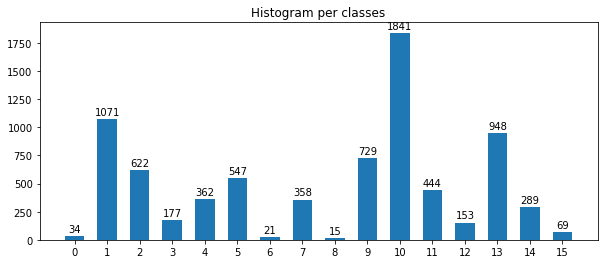

In [26]:
plot_histogram(y_test_indiana_labels)
plot_histogram(y_train_indiana_labels)

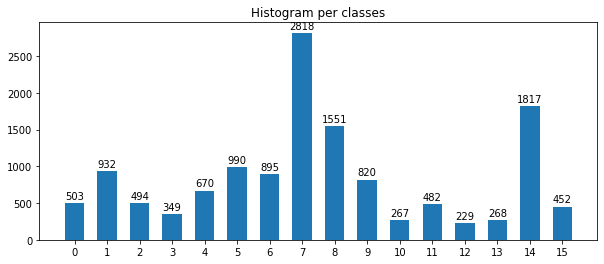

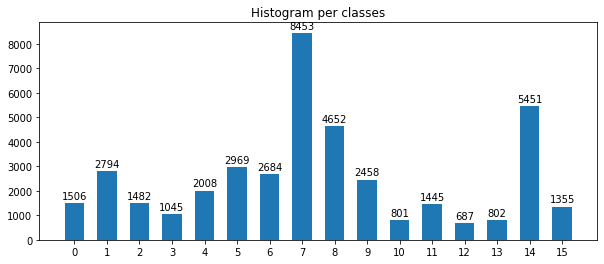

In [27]:
plot_histogram(y_test_salinas_labels)
plot_histogram(y_train_salinas_labels)

## Random Forest

In [28]:
modelRF_indiana = RandomForestClassifier(n_estimators=100, verbose=1, n_jobs=8)
modelRF_salinas = RandomForestClassifier(n_estimators=100, verbose=1, n_jobs=8)

In [29]:
modelRF_indiana.fit(x_train_indiana, y_train_indiana_labels)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.0s finished


RandomForestClassifier(n_jobs=8, verbose=1)

In [30]:
modelRF_salinas.fit(x_train_salinas, y_train_salinas_labels)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.4s finished


RandomForestClassifier(n_jobs=8, verbose=1)

In [31]:
# training score
modelRF_indiana.score(x_train_indiana, y_train_indiana_labels)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


1.0

In [32]:
# training score
modelRF_salinas.score(x_train_salinas, y_train_salinas_labels)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished


0.9999753646038628

In [33]:
modelRF_indiana.verbose = 0
for cluster in labels_indiana:
    idxs = np.argwhere(y_train_indiana_labels == cluster).flatten()
    score = modelRF_indiana.score(x_train_indiana[idxs], y_train_indiana_labels[idxs])
    print("Cluster: {}".format(cluster))
    print("Nb samples: {}".format(y_train_indiana_labels[idxs].size))
    print("Score: {}".format(score))
    print("-----------")

Cluster: 0
Nb samples: 34
Score: 1.0
-----------
Cluster: 1
Nb samples: 1071
Score: 1.0
-----------
Cluster: 2
Nb samples: 622
Score: 1.0
-----------
Cluster: 3
Nb samples: 177
Score: 1.0
-----------
Cluster: 4
Nb samples: 362
Score: 1.0
-----------
Cluster: 5
Nb samples: 547
Score: 1.0
-----------
Cluster: 6
Nb samples: 21
Score: 1.0
-----------
Cluster: 7
Nb samples: 358
Score: 1.0
-----------
Cluster: 8
Nb samples: 15
Score: 1.0
-----------
Cluster: 9
Nb samples: 729
Score: 1.0
-----------
Cluster: 10
Nb samples: 1841
Score: 1.0
-----------
Cluster: 11
Nb samples: 444
Score: 1.0
-----------
Cluster: 12
Nb samples: 153
Score: 1.0
-----------
Cluster: 13
Nb samples: 948
Score: 1.0
-----------
Cluster: 14
Nb samples: 289
Score: 1.0
-----------
Cluster: 15
Nb samples: 69
Score: 1.0
-----------


In [34]:
modelRF_salinas.verbose = 0
for cluster in labels_salinas:
    idxs = np.argwhere(y_train_salinas_labels == cluster).flatten()
    score = modelRF_salinas.score(x_train_salinas[idxs], y_train_salinas_labels[idxs])
    print("Cluster: {}".format(cluster))
    print("Nb samples: {}".format(y_train_salinas_labels[idxs].size))
    print("Score: {}".format(score))
    print("-----------")

Cluster: 0
Nb samples: 1506
Score: 1.0
-----------
Cluster: 1
Nb samples: 2794
Score: 1.0
-----------
Cluster: 2
Nb samples: 1482
Score: 1.0
-----------
Cluster: 3
Nb samples: 1045
Score: 1.0
-----------
Cluster: 4
Nb samples: 2008
Score: 1.0
-----------
Cluster: 5
Nb samples: 2969
Score: 1.0
-----------
Cluster: 6
Nb samples: 2684
Score: 1.0
-----------
Cluster: 7
Nb samples: 8453
Score: 1.0
-----------
Cluster: 8
Nb samples: 4652
Score: 1.0
-----------
Cluster: 9
Nb samples: 2458
Score: 1.0
-----------
Cluster: 10
Nb samples: 801
Score: 1.0
-----------
Cluster: 11
Nb samples: 1445
Score: 1.0
-----------
Cluster: 12
Nb samples: 687
Score: 1.0
-----------
Cluster: 13
Nb samples: 802
Score: 1.0
-----------
Cluster: 14
Nb samples: 5451
Score: 0.9998165474224913
-----------
Cluster: 15
Nb samples: 1355
Score: 1.0
-----------


In [35]:
# testing score
modelRF_indiana.score(x_test_indiana, y_test_indiana_labels)

0.8201634877384196

In [36]:
# testing score
modelRF_salinas.score(x_test_salinas, y_test_salinas_labels)

0.9418630420329467

In [37]:
mean_score = 0
for cluster in labels_indiana:
    idxs = np.argwhere(y_test_indiana_labels == cluster).flatten()
    score = modelRF_indiana.score(x_test_indiana[idxs], y_test_indiana_labels[idxs])
    mean_score += score
    print("Cluster: {}".format(cluster))
    print("Nb samples: {}".format(y_test_indiana_labels[idxs].size))
    print("Score: {}".format(score))
    print("-----------")
    
mean_score /= len(labels_indiana)
print(mean_score)

Cluster: 0
Nb samples: 12
Score: 0.3333333333333333
-----------
Cluster: 1
Nb samples: 357
Score: 0.7619047619047619
-----------
Cluster: 2
Nb samples: 208
Score: 0.5673076923076923
-----------
Cluster: 3
Nb samples: 60
Score: 0.43333333333333335
-----------
Cluster: 4
Nb samples: 121
Score: 0.8677685950413223
-----------
Cluster: 5
Nb samples: 183
Score: 0.9726775956284153
-----------
Cluster: 6
Nb samples: 7
Score: 0.8571428571428571
-----------
Cluster: 7
Nb samples: 120
Score: 0.975
-----------
Cluster: 8
Nb samples: 5
Score: 0.4
-----------
Cluster: 9
Nb samples: 243
Score: 0.7942386831275721
-----------
Cluster: 10
Nb samples: 614
Score: 0.9087947882736156
-----------
Cluster: 11
Nb samples: 149
Score: 0.6040268456375839
-----------
Cluster: 12
Nb samples: 52
Score: 0.9615384615384616
-----------
Cluster: 13
Nb samples: 317
Score: 0.9905362776025236
-----------
Cluster: 14
Nb samples: 97
Score: 0.5463917525773195
-----------
Cluster: 15
Nb samples: 24
Score: 0.875
-----------
0.7

In [38]:
mean_score = 0
for cluster in labels_salinas:
    idxs = np.argwhere(y_test_salinas_labels == cluster).flatten()
    score = modelRF_salinas.score(x_test_salinas[idxs], y_test_salinas_labels[idxs])
    mean_score += score
    print("Cluster: {}".format(cluster))
    print("Nb samples: {}".format(y_test_salinas_labels[idxs].size))
    print("Score: {}".format(score))
    print("-----------")
    
mean_score /= len(labels_salinas)
print(mean_score)

Cluster: 0
Nb samples: 503
Score: 0.9960238568588469
-----------
Cluster: 1
Nb samples: 932
Score: 1.0
-----------
Cluster: 2
Nb samples: 494
Score: 0.9959514170040485
-----------
Cluster: 3
Nb samples: 349
Score: 0.9885386819484241
-----------
Cluster: 4
Nb samples: 670
Score: 0.9880597014925373
-----------
Cluster: 5
Nb samples: 990
Score: 1.0
-----------
Cluster: 6
Nb samples: 895
Score: 0.9988826815642458
-----------
Cluster: 7
Nb samples: 2818
Score: 0.9006387508871541
-----------
Cluster: 8
Nb samples: 1551
Score: 0.9980657640232108
-----------
Cluster: 9
Nb samples: 820
Score: 0.9682926829268292
-----------
Cluster: 10
Nb samples: 267
Score: 0.9850187265917603
-----------
Cluster: 11
Nb samples: 482
Score: 1.0
-----------
Cluster: 12
Nb samples: 229
Score: 0.9956331877729258
-----------
Cluster: 13
Nb samples: 268
Score: 0.9813432835820896
-----------
Cluster: 14
Nb samples: 1817
Score: 0.7539900935608145
-----------
Cluster: 15
Nb samples: 452
Score: 0.9911504424778761
--------

In [39]:
preds_indiana = modelRF_indiana.predict(X_indiana_reduced)

In [40]:
preds_salinas = modelRF_salinas.predict(X_salinas_reduced)

In [41]:
#preds_test = modelRF.predict(x_test_indiana)
#preds_train = modelRF.predict(x_train_indiana)

In [42]:
#preds_test = y_test_indiana_labels
#preds_train = y_train_indiana_labels

In [43]:
print(indiana_labels.shape)
print(preds_indiana.shape)

(10249,)
(10249,)


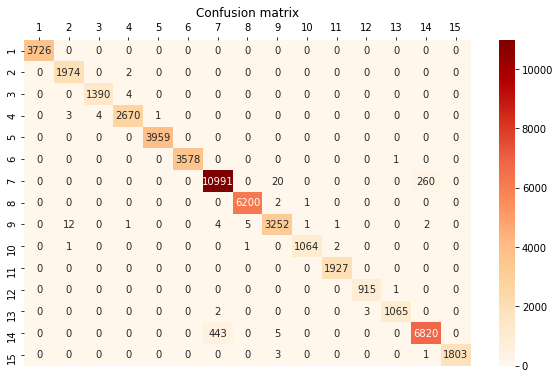

In [44]:
plot_confusion_matrix(salinas_labels, preds_salinas + 1, class_names=np.arange(1, 16))

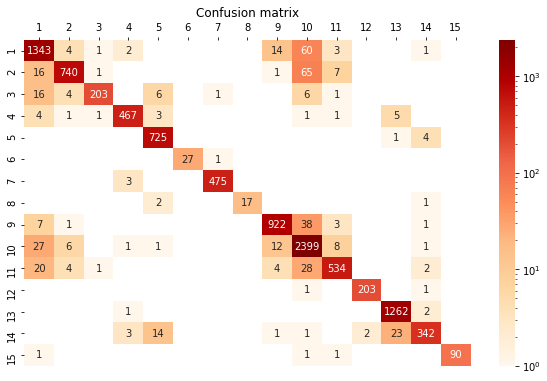

In [47]:
plot_confusion_matrix(indiana_labels, preds_indiana + 1, class_names=np.arange(1, 16), log=True)

In [44]:
#sum_train = 0
#sum_test = 0

#preds_indiana = np.empty([])
#y_indiana_labels = np.array([])

#for cluster in labels:
#    idx = int(count[cluster] * 0.75)
    
#    preds_indiana = np.hstack((preds_indiana, preds_train[sum_train:sum_train+idx]))
#    preds_indiana = np.hstack((preds_indiana, preds_test[sum_test:sum_test+count[cluster]-idx]))
    
#    y_indiana_labels = np.hstack((y_indiana_labels, y_train_indiana_labels[sum_train:sum_train+idx]))
#    y_indiana_labels = np.hstack((y_indiana_labels, y_test_indiana_labels[sum_test:sum_test+count[cluster]-idx]))
    
#    print("Cluster: {}".format(cluster))
#    print("Nb total samples: {}".format(count[cluster]))
#    print("Nb samples train: {}".format(idx))
#    print("Nb samples test: {}".format(count[cluster] - idx))
#    print("---------------")
#    sum_train += idx
#    sum_test += count[cluster] - idx

In [45]:
# unargsort
#preds_indiana = preds_indiana[unmapping_argsort]
#y_indiana_labels = y_indiana_labels[unmapping_argsort]

In [46]:
#preds_img = np.zeros((indiana_img.shape[0] * indiana_img.shape[1]))
#label_img = np.zeros((indiana_img.shape[0] * indiana_img.shape[1]))

In [47]:
# unshuffle
#preds_img[X_indiana_idx] = preds_indiana[unmapping_shuffle.astype(int)]
#label_img[X_indiana_idx] = y_indiana_labels[unmapping_shuffle.astype(int)]

In [48]:
#preds_img[X_indiana_idx] = preds
#label_img[X_indiana_idx] = y_indiana_labels

In [49]:
#print(preds_img.shape)
#print(label_img.shape)

In [50]:
salinas_preds_img = np.zeros((salinas_img.shape[0] * salinas_img.shape[1]))
salinas_label_img = np.zeros((salinas_img.shape[0] * salinas_img.shape[1]))

In [52]:
salinas_preds_img[X_salinas_idx] = preds_salinas + 1
salinas_preds_img = salinas_preds_img.reshape((salinas_img.shape[0], salinas_img.shape[1]))

In [53]:
salinas_label_img[X_salinas_idx] = salinas_labels
salinas_label_img = salinas_label_img.reshape((salinas_img.shape[0], salinas_img.shape[1]))

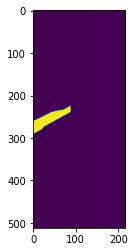

In [54]:
plt.imshow(get_label(salinas_label_img, 1))
plt.show()

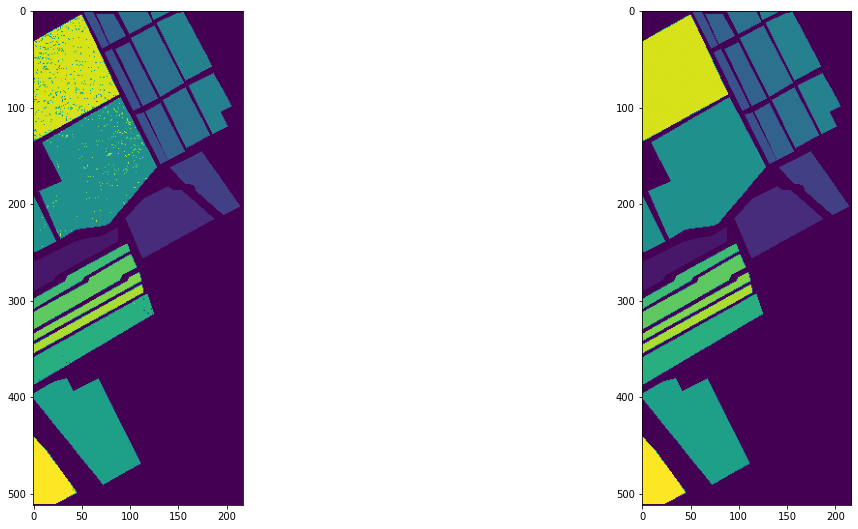

In [55]:
plot_two_figures(salinas_preds_img, salinas_label_img, figsize=(20, 20))

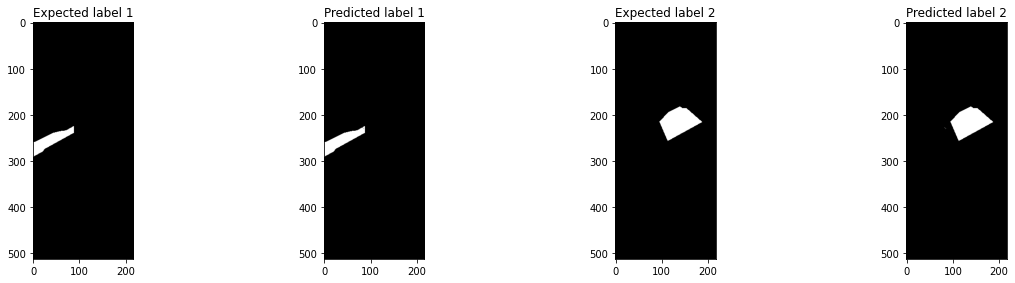

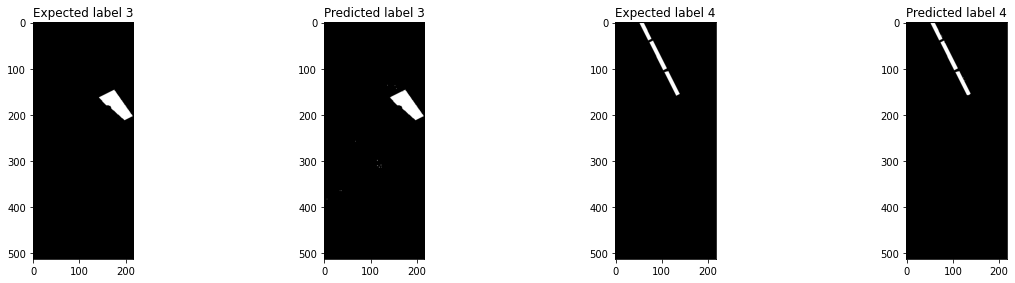

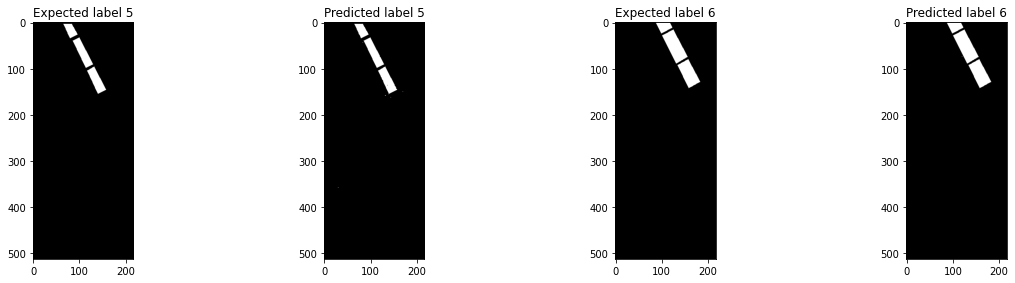

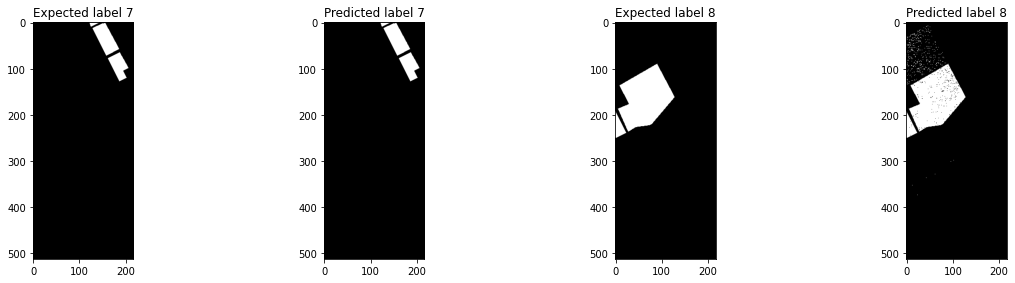

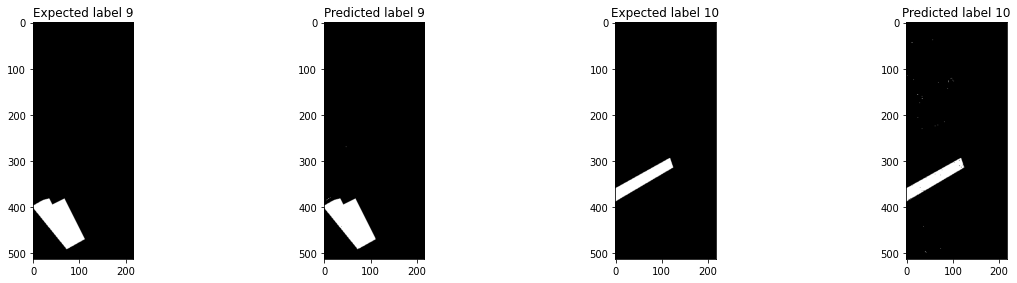

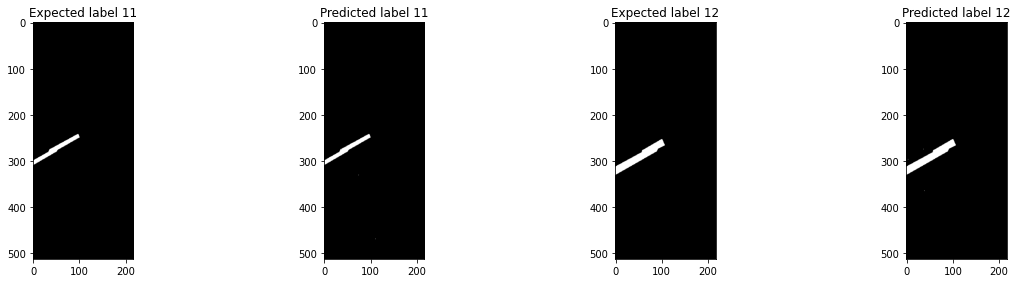

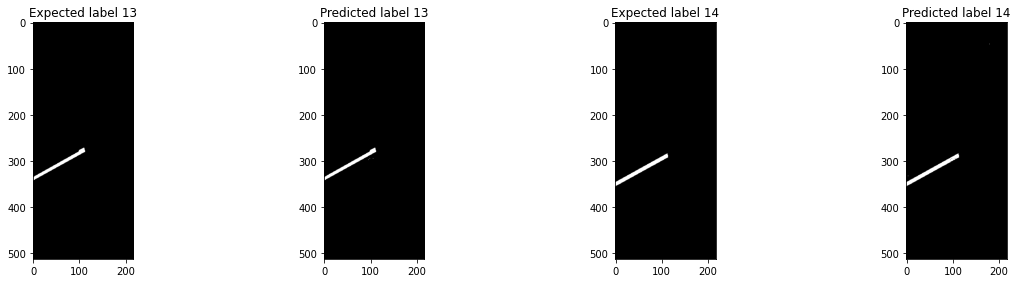

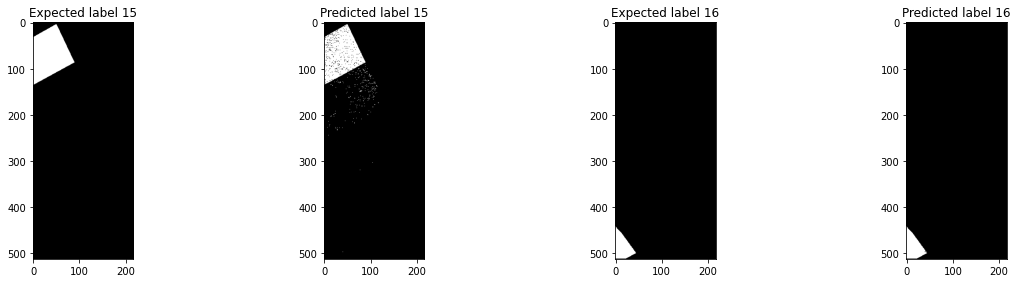

In [63]:
plot_each_labels(salinas_label_img, salinas_preds_img, n_cluster_salinas, figsize=(20, 20), cmap='gray')

In [58]:
indiana_preds_img = np.zeros((indiana_img.shape[0] * indiana_img.shape[1]))
indiana_label_img = np.zeros((indiana_img.shape[0] * indiana_img.shape[1]))

In [59]:
indiana_preds_img[X_indiana_idx] = preds_indiana + 1
indiana_preds_img = indiana_preds_img.reshape((indiana_img.shape[0], indiana_img.shape[1]))

In [60]:
indiana_label_img[X_indiana_idx] = indiana_labels
indiana_label_img = indiana_label_img.reshape((indiana_img.shape[0], indiana_img.shape[1]))

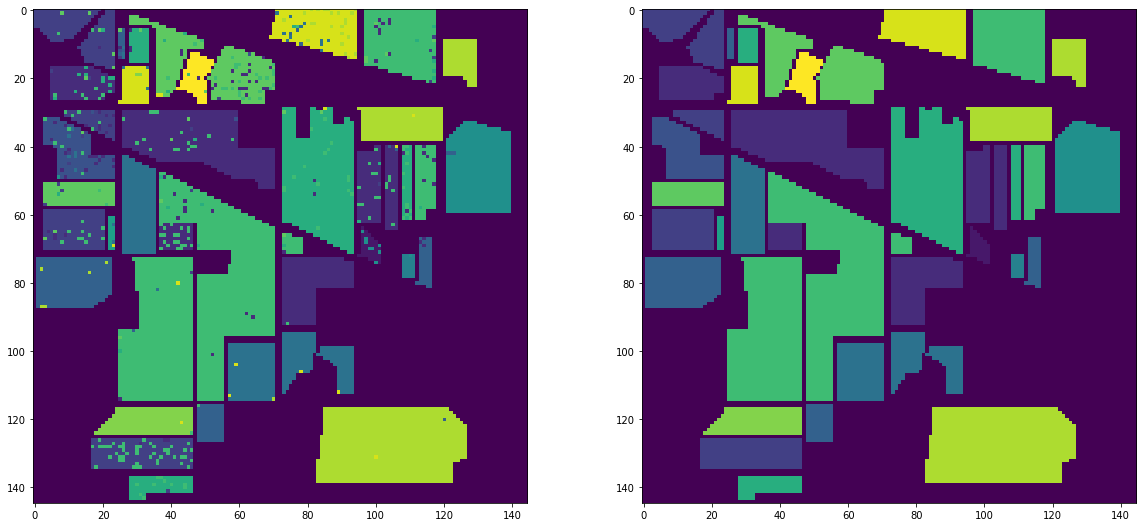

In [61]:
plot_two_figures(indiana_preds_img, indiana_label_img, figsize=(20, 20))

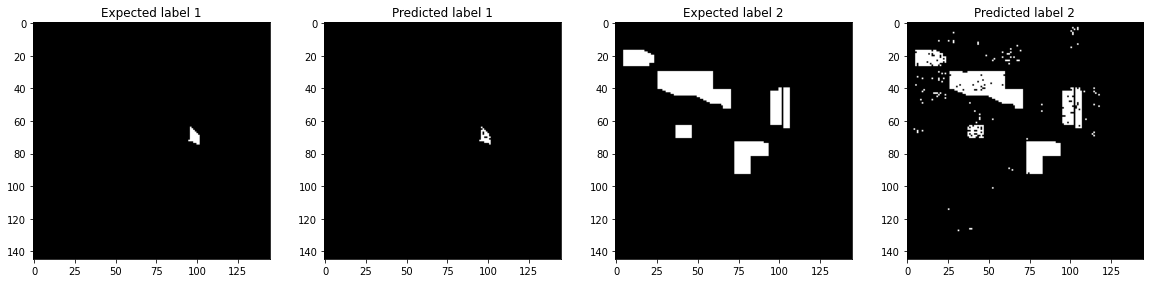

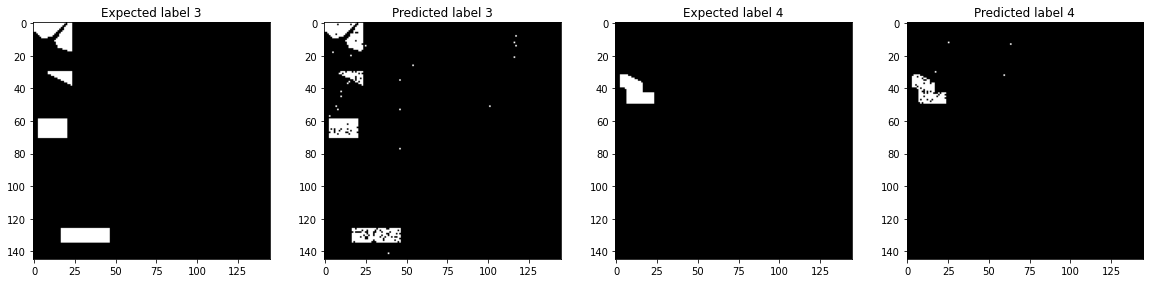

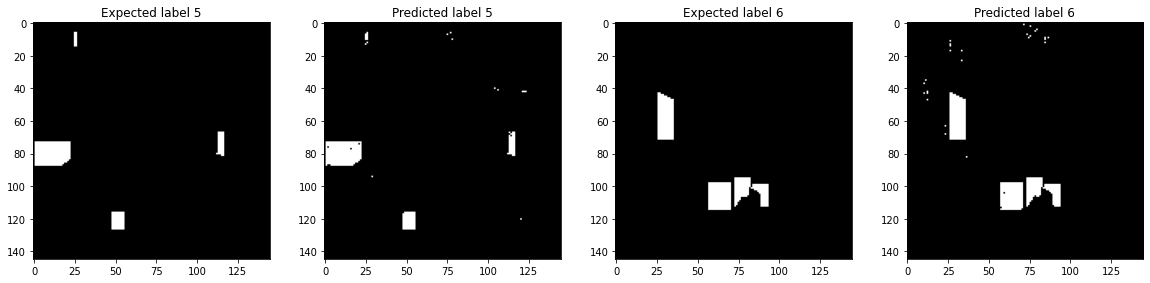

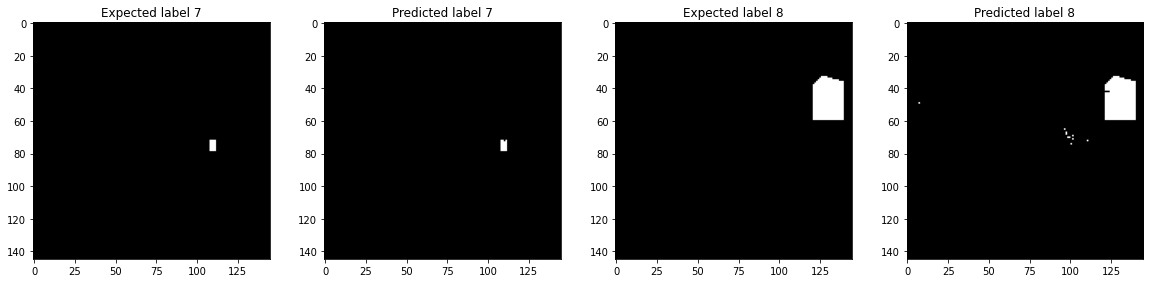

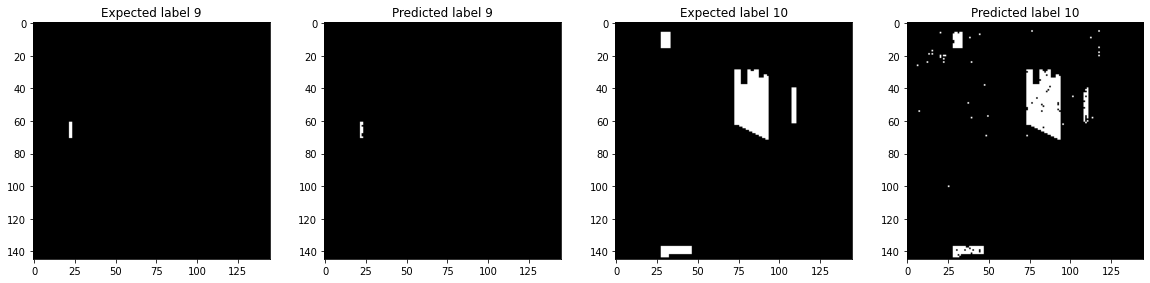

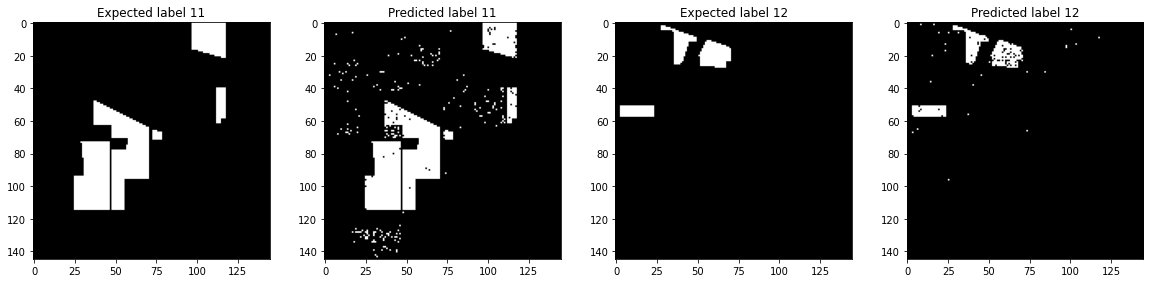

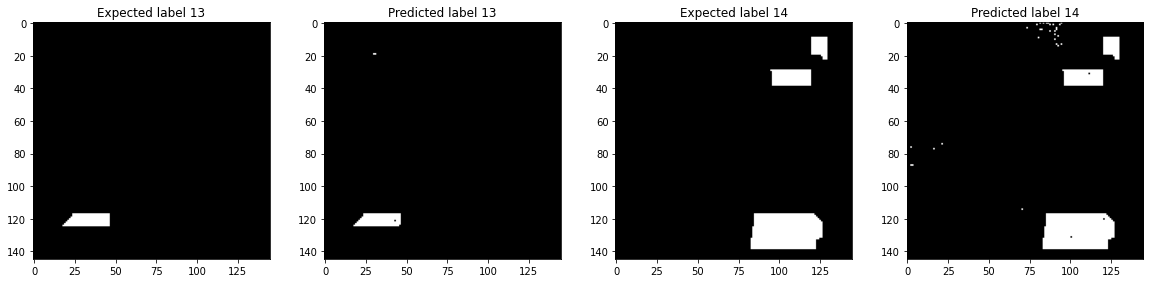

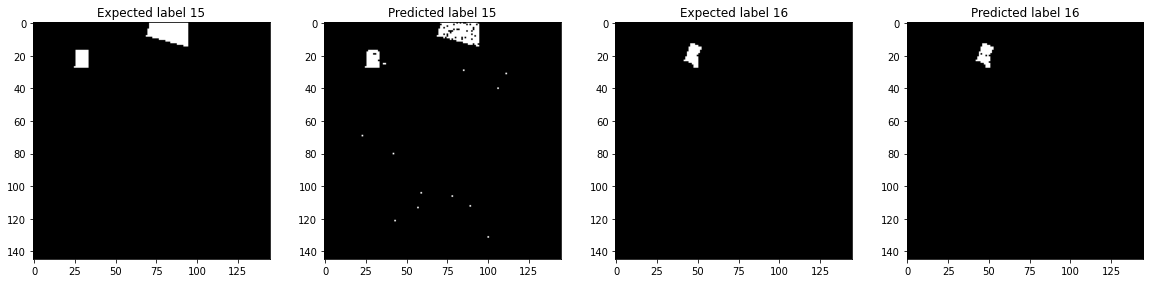

In [62]:
plot_each_labels(indiana_label_img, indiana_preds_img, n_cluster_indiana, figsize=(20, 20), cmap='gray')